# Lab 2a - Pytorch Basics
In today's lab we're going to actually get to build and train a complete neural network! The type of network we'll build is called a [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron), which is fantastic for tabular data like what we'll be dealing with.

The task is to predict the quality of wine based on features like alcohol content and density, using a [publically available dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). The target variable of "quality" is a subjective measure of the wine's quality based on expert tasters.

We'll go through a number of steps:
 * Acquiring and exploring the dataset
 * Splitting the dataset into train / validation / test partitions
 * Implementing a neural network and optimiser
 * Writing a training loop
 * Visualising our results

<font color='red'>In this notebook we will approach this as a regression problem where we try to predict the numerical value representing the quality rating (between 0 and 9). In the lab02b notebook we will approach this as a classification problem instead by making some simple modifications. </font>

## Data Acquisition
Let's acquire our dataset! To read and manipulate it, we'll be using [Pandas](https://pandas.pydata.org/), which is great for tabular data.

Fortunately for us, Pandas is able to load a dataset when given either a local file path or a web URL. We'll take advantage of the latter, and directly download the dataset from the web.

In [ ]:
# Import Pandas
import pandas as pd

# There are two datasets available, but we'll just work with the larger, white
# wine dataset. Feel free to play around with the red wine dataset once you've
# finished the lab
red_wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
white_wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

# It's a single function call to load a dataset. CSV files typically use commas
# as delimiters between records, but our dataset uses semicolons so we had to
# specify it with the "delimiter" argument.
all_data = pd.read_csv(white_wine_url, delimiter=';')

print(type(all_data))

<class 'pandas.core.frame.DataFrame'>


As we can see above, the type of object we just created is a `DataFrame`. This is how Pandas represent tabular data and provides a lot of functionality!

Open [this link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to the class documentation with a list of methods and their descriptions, and refer to it frequently during this lab.

## Data Exploration
The first step in any project is to get familiar with the dataset. It can be very tempting to jump ahead and start building a neural network, but a lot of unexpected problems can arise if you don't understand the dataset. This dataset is already very clean - meaning that there are few problems with it - so we don't need to work too hard at this.

First up, let's just have a look at a few rows of the dataset. This is achieved by calling the method `head` on your `DataFrame`. Calling this method will display a table of the first few example in the dataset.

In [ ]:
all_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


As we can see, our dataset has a number of columns including density, pH and alcohol contents. \
Our task today is to predict the last column - **quality**. This is a 0-10 value indicating the wine's quality score, as measured by wine tasting experts.
A score of 0 is terrible wine, and a score of 10 is the best wine possible.

### Check for Missing Data
It's very important that we check for any missing data before using it. Passing a missing value into a neural network will result in unexpected behaviour, and almost certainly degrade its performance. To avoid this we first check if there are any null values, and fix those that we encounter.

*This dataset doesn't contain any null values, so we don't need to fix it. Common strategies include replacing nulls with the mean value for that attribute, the value zero, or just deleting the entire example.*

In [ ]:
# Set each value in the DataFrame to True where it's null, then count the number
# of True values
all_data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Plot Feature Distributions
Now that we're confident that there is no missing data, we can look at the distribution of the features. We'll do this using a histogram, which is a type of bar graph which counts the number of values that fall into different regions.

Luckily for us, `DataFrame` objects have a method called `hist` which does the hard work for us!

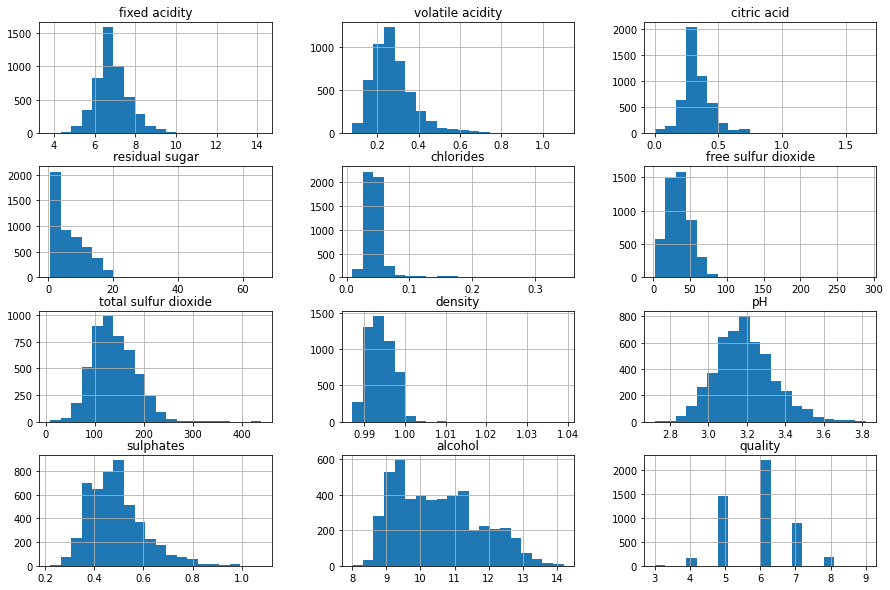

In [ ]:
all_data.hist(bins=20, figsize=(15, 10));

Looking at the distribution of the target attribute `quality`, we can see that there are very few examples with values of 3, 4, 8, and 9. This means that the dataset is unbalanced, usually resulting a model that performs poorly on the underrepresented examples. We would normally apply [a few tricks](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) to resolve this, but we will just ignore it for this lab.

## Partition the Dataset
Now we'll split our dataset into three partitions - training, validation and testing. Each of these partitions have a specific function in guiding the experimental process:
 * Training: the partition which the model directly uses during weight optimisation during training.
 * Validation: the model isn't allowed to use this partition during training; we instead fine-tune our hyperparameters (e.g. initial learning rate, optimization algorithm used, etc.) based on the model's performance on this sample.
 * Testing: this partition is used to evaluate model performance on previously unseen data. We shouldn't use this partition to optimise the model *or* fine-tune hyperparameters. Usually you only use this partition once at the very end when you want to see just how well your trained model generalizes to completely new data.

As our task is to predict the wine quality from the other attributes, we will first have to separate the wine quality column from the rest. We typically call the input features `x` and the target features `y`.

Before doing so, let's take a look at how to handle columns in Pandas.



In [ ]:
# We use the following function to extract a single column from a DataFrame. 
# The function returns a series instead of a DataFrame. 
# A series is essentially a 1D array, so it doesn't have any concept of columns.
print(all_data["sulphates"])
print('-' * 50)

# Here we end up with the same data as above, but this time we receive a DataFrame
# with a single column (note how we passed the column name in a list) instead of series.
print(all_data[["sulphates"]])
print('-' * 50)

# The code below returns multiple columns
print(all_data[["sulphates", "density"]])
print('-' * 50)

# The code below returns all *but* one column. We need to pass axis=1 to indicate
# that we're dropping a column, not a row.
print(all_data.drop("sulphates", axis=1))
print('-' * 50)

0       0.45
1       0.49
2       0.44
3       0.40
4       0.40
        ... 
4893    0.50
4894    0.46
4895    0.46
4896    0.38
4897    0.32
Name: sulphates, Length: 4898, dtype: float64
--------------------------------------------------
      sulphates
0          0.45
1          0.49
2          0.44
3          0.40
4          0.40
...         ...
4893       0.50
4894       0.46
4895       0.46
4896       0.38
4897       0.32

[4898 rows x 1 columns]
--------------------------------------------------
      sulphates  density
0          0.45  1.00100
1          0.49  0.99400
2          0.44  0.99510
3          0.40  0.99560
4          0.40  0.99560
...         ...      ...
4893       0.50  0.99114
4894       0.46  0.99490
4895       0.46  0.99254
4896       0.38  0.98869
4897       0.32  0.98941

[4898 rows x 2 columns]
--------------------------------------------------
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.

<font color='red'>In the next cell, separate the inputs and labels into two variables, using the cell above for reference.</font>

In [ ]:
target_column = "quality"

# TODO: Extract just the *input* features. Instead of specifying all of the features we
# want, we should drop the feature we *don't* want.
# x_data = ...

# SOLUTION LINE
x_data = all_data.drop(target_column, axis=1)

# TODO: Extract the target feature. We don't want a Series here, but a DataFrame
# with one column (see the above cell)
# y_data = ...

# SOLUTION LINE
y_data = all_data[[target_column]]

# If your implementation is correct the shape of y_data should be (4898, 1)
# So y_data is a 2D tensor containing 4898 examples and just 1 feature.
print("y_data shape:", y_data.shape) 

# Just like with tensors, we can print the shape
num_examples = x_data.shape[0]
num_input_features = x_data.shape[1]

# If your implementation is correct the number of samples should be 4898
print("Number of examples:", num_examples) 

# If your implementation is correct the number of input features should be 11
print("Number of input features:", num_input_features)

# If your implementation the shape of the x_data tensor should be (4898, 11)
# which means it is a 2D array where each row represents one example and each
# column represents one feature
print("x_data shape:", x_data.shape )

y_data shape: (4898, 1)
Number of examples: 4898
Number of input features: 11
x_data shape: (4898, 11)


We've split the dataset into inputs and targets, but now we need to actually partition it into train, val, and test splits. There are numerous ways of doing this, but here we'll present the most simple.

First up, we'll convert our `DataFrame` objects into tensors so we can have torch perform the random partitioning.

<font color='red'>In the next cell, complete the code to convert the data to PyTorch tensors.</font>

In [ ]:
# Import Torch and the dataset utilities we need
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# The percentages for each partition
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
# Ensure that the splits add to 100%
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1


# TODO: Create two tensors and initialise them with x_data.values and y_data.values.
# The dtype should be torch.float32. DataFrame.values directly returns the 2D
# data in the dataframe, which is what Torch requires to initialise a tensor.
# we have done the initialization for x_tensor for you. Please do something similar
# the y_tensor.

x_tensor = torch.tensor(x_data.values, dtype=torch.float32)
# y_tensor = ...

# SOLUTION LINE
y_tensor = torch.tensor(y_data.values, dtype=torch.float32)

assert torch.is_tensor(x_tensor) and x_tensor.dtype == torch.float32
assert torch.is_tensor(y_tensor) and y_tensor.dtype == torch.float32

# Now we construct a TensorDataset - a simple class used to associate each x and
# y value in our tensors.
full_dataset = TensorDataset(x_tensor, y_tensor)

Now we just need to compute the number of examples in each partition and actually split the dataset into train, val, and test.

<font color='red'>In the next cell, complete the code to split the data into three partitions.</font>

In [ ]:
# Calculate the number of examples in each partition
train_size = int(TRAIN_SPLIT * len(all_data))
val_size = int(VAL_SPLIT * len(all_data))
test_size = len(all_data) - train_size - val_size

print("Train examples:     ", train_size)
print("Validation examples:", val_size)
print("Test examples:      ", test_size)

# Before we actually split the dataset, we seed Torch's random number generator.
# This ensure that we end up with the exact same partitions every time it's run.
torch.manual_seed(42)

# TODO: Split the dataset using the random_split function we imported earlier.
# The function takes a dataset and a list of partition lengths.
# Hint: We already have all of these variables available
#       You can see an example here:
#       https://www.programcreek.com/python/example/125046/torch.utils.data.random_split
# train_dataset, val_dataset, test_dataset = random_split(...)

# SOLUTION LINE
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

Train examples:      3918
Validation examples: 489
Test examples:       491


## Number of data items in each dataset

A simple way to find out the number of data items in a dataset is to use the len function.

In [ ]:
print("train set size: ", len(train_dataset))
print("validation set size: ", len(val_dataset))
print("test set size: ", len(test_dataset))


train set size:  3918
validation set size:  489
test set size:  491


## Create the DataLoaders
Torch uses `DataLoader` objects during training to sample values from each `Dataset`. The `DataLoader` handles shuffling the data, as well as gathering the examples into batches. We will need three loaders, as we have three partitions.

<font color='red'>In the next cell, initialise three `DataLoader` objects - one for each of the partitions.</font>

In [ ]:
# When you've finished the lab, try modifying the batch size to see what effect
# it has on your results
BATCH_SIZE = 64

# TODO: Construct a DataLoader for each Dataset. The constructor takes three
# arguments - a Dataset, the batch size, and a boolean indicating whether it
# should shuffled. We will set shuffle=True for train dataloader and 
# shuffle=False for the other two. We have written the train_loader for you
# you should write the rest.

train_loader = train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(...
# test_loader = DataLoader(...

# SOLUTION LINE
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
# SOLUTION LINE
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

We now have three DataLoaders, but how do they work?

In the previous lab we saw that we can iterate over a list of values very easily in Python:
```python
for x in [1, 2, 3]:
    # Do something with x
```

The `DataLoader` class gives us that same functionality but with a batch of inputs and labels at a time instead of a single value:
```python
for batch in my_dataloader:
    inputs, labels = batch  # <- tuple unpacking*
    # Do something with the inputs and labels
```
*_You might not have seen tuple unpacking before. This Python feature allows you to extract values from a list or tuple. For example, this code would give x and y the values of 1 and 2, respectively: `x, y = (1, 2)`_
\
\
<font color='red'>In the next cell, iterate over the training `DataLoader` and insert code to do the following</font>:
 1. Unpack the inputs and labels for the batch
 1. Print out their shapes
 1. Exit the loop early by using a `break` statement. (so we don't loop over the entire dataset)

 The output should be for the input and label shapes:
 \
 torch.Size([64, 11]) torch.Size([64, 1])


In [ ]:
# TODO: Loop over the training dataloader
# SOLUTION LINE:
for batch in train_loader:
  # 1. Unpack the inputs and labels for the batch
  # SOLUTION LINE:
  inputs, labels = batch

  # 2. Print out their shapes
  # SOLUTION LINE:
  print(inputs.shape, labels.shape)

  # 3. Exit early with a break statement
  # SOLUTION LINE:
  break

torch.Size([64, 11]) torch.Size([64, 1])


Take note of the shapes:
 * The input shape is `[batch_size, num_input_features]`
 * The output shape is `[batch_size, num_target_features]`

## Set Up for Training
We're finally done with data manipulation! Data manipulation is typically the most time-intensive and important task in a deep-learning project, so consider yourself lucky!

Now we'll go through everything from building the model, to writing a complete training loop!

### Enable GPU Training *(if available)*
The rise in popularity of deep learning is largely a result of the availability of good Graphics Processing Units. So although it's not required, it's definitely good to utilise a GPU if you can.

It's exceptionally easy to use a compatible GPU in Pytorch - we can do it in just a few lines of code!

In [ ]:
# By default we'll assume that GPU acceleration isn't available
device = torch.device("cpu")

# Check if GPU acceleration is available (requires a CUDA-compatible GPU) and
# set the device variable accordingly. If the computer has more than one GPU,
# you can specify which one by replacing 0 with a different index
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Training on cuda:0


### Define the Model
Torch allows us to build very complex custom models. For today's task we don't need anything complicated - we'll save that for later labs 😉

To implement a model, we need to write a subclass of `nn.Module`. This class should implement a `forward` function, which is called with a batch of inputs to make predicitons.

Our model will be composed of two linear layers, with an activation function inbetween. The easiest way to do this is to pass a `nn.Sequential` object with the layers as arguments. Torch stitches them together, so inputs are passed through each of the layers sequentially.

<font color='red'>In the next cell, initialise a `Sequential` module with the specified layers.</font> \
Open up the links below for documentation and examples:
 * [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
 * [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
 * [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

In [ ]:
# Import the neural network module of Pytorch. We access its methods like "nn.Linear"
import torch.nn as nn

# Our model class must subclass nn.Module
class MLP(nn.Module):
    # The __init__ method is similar to a constructor like you find in other
    # languages. We will take the device as an argument to transfer the model to the GPU
    def __init__(self, device):
        super().__init__()
        # TODO: Initialise a Sequential module consisting of the below layers, and
        # store it in the member variable self.seq
        #  - a Linear layer mapping from num_input_features to 20 hidden features
        #  - a ReLU activation layer
        #  - a Linear layer mapping from 20 hidden features to a single feature (the wine quality)
        # You can look here for an example:
        #     https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        # self.seq = nn.Sequential(...

        # SOLUTION LINE
        self.seq = nn.Sequential(nn.Linear(num_input_features, 20),
                          nn.ReLU(),
                          nn.Linear(20, 1))
    
        # The model stays on the CPU by default. Calling the "to" method transfers
        # the model weights to whichever device we specified
        self.to(device)

    # Our forward method simply takes the input batch x, passes it through our
    # Sequential module, and returns the outputs (predictions)
    def forward(self, x):
        return self.seq(x)

## Simple Training loop

In the cell below we will write a very simple training loop to train the above model. This will allow you to see the whole training process at once. However, in proper production systems programmers write code in a more modular fashion. Maximizing the amount of reuse of code between, train and test loops. In the rest of the lab we will show you the more modular way to structure your code, which is closer to what is actually used in industry.

In [ ]:
import torch.optim as optim

# Use the mean squared error as the loss function
criterion = nn.MSELoss()
# Use MLP as the model
model = MLP(device)
# Use the SGD optimizer with initial learning rate set to 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# The number of times we loop over the entire dataset
total_epochs = 10
for epoch in range(total_epochs):  # loop over the dataset multiple times

    # The following is computed in a single pass through the dataset
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Copy the data to the specified device
        inputs, labels = inputs.to(device), labels.to(device)

        # Put the model into train mode
        model.train()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)

        # Compute the loss using the loss function
        loss = criterion(outputs, labels)

        # Perform backprop using the loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

     # print statistics
    print('epoch: %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
        
print('Finished Training')

epoch: 1 loss: 5.040
epoch: 2 loss: 2.930
epoch: 3 loss: 2.528
epoch: 4 loss: 2.257
epoch: 5 loss: 1.982
epoch: 6 loss: 1.820
epoch: 7 loss: 1.660
epoch: 8 loss: 1.558
epoch: 9 loss: 1.618
epoch: 10 loss: 1.259
Finished Training


## Simple Testing loop


In [ ]:
running_loss = 0.0
for i, data in enumerate(test_loader, 0):
   # get the inputs; data is a list of [inputs, labels]
   inputs, labels = data

   # Copy the data to the specified device
   inputs, labels = inputs.to(device), labels.to(device)

   # Put the model into eval mode
   model.eval()

   with torch.no_grad():
    # Forward + backward + optimize
    outputs = model(inputs)

    # Compute the loss using the loss function
    loss = criterion(outputs, labels)
    running_loss += loss.item()

print("test loss: ", running_loss/len(test_loader))


test loss:  2.4354262202978134


# Modular training and test code follows

The following code will decompose the training loop into functions which maximizes the reuse of code within this project and also allows the code to be reused across other projects.

### Set Up the Loss Function
In order to train the network, we need a loss function! A typical loss function for a regression task like this is [mean squared error (MSE)](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

We'll try different loss functions later, but this will do for now.

<font color='red'>In the next cell, initialise the MSE loss function</font>. \
Refer to the above link if necessary.

In [ ]:
# Instantiate the MSE loss function with no arguments
# loss_func = ...

# SOLUTION LINE
loss_func = nn.MSELoss()
# SOLUTION LINE
# loss_func = nn.L1Loss()
# SOLUTION LINE
# loss_func = nn.SmoothL1Loss()

### Set Up the Optimiser
An optimiser is used to update the model weights, and there are many variants available. For now we'll use stochastic gradient descent (SGD), which is the simplest optimiser. We'll try some variants later on and see how it effects our results.

In [ ]:
# We'll construct our optimiser inside a function - some optimisers have variables
# and we want to make sure they start fresh each time we train a model.
def construct_optimizer(model):
    # When constructing an optimiser, must we provide the model parameters we
    # with to optimise
    return torch.optim.SGD(model.parameters(), lr=0.0001)

    # SOLUTION LINE
    # return torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)
    # SOLUTION LINE
    # return torch.optim.Adam(model.parameters(), lr=0.001)

### Implement the Training Loop
Training requires quite a few things to happen, so we'll break it up into different functions to make it easier.

First we'll write a function which performs a single training step on a batch of inputs/targets. In this function, we'll:
 1. Copy the data to the GPU *(if available)*
 2. Put the model into `train` mode *(some layers operate differently at train and test time)*
 3. Set all parameter gradients to zero *(to start fresh in every training step)*
 4. Have the model make a prediction for the batch
 5. Compute the loss *(between predictions and targets)*
 6. Backpropagate the loss to compute gradients
 7. Update model weights

So we can visualise the training procedure, we'll return the loss for the batch. We'll also return the predictions, as they may come in handy.

As there are a lot of steps, this has been implemented for you. Read the code and comments thoroughly, as it's vital to understand the training procedure.

In [ ]:
def train_step(model, inputs, labels, loss_func, optimizer, device):
    # 1. Copy the data to the specified device
    inputs, labels = inputs.to(device), labels.to(device)

    # 2. Put the model into train mode
    model.train()
    
    # 3. Set all parameter gradients to zero
    optimizer.zero_grad()

    # 4. Have the model make a prediction for the batch
    outputs = model(inputs)

    # 5. Compute the loss
    loss = loss_func(outputs, labels)

    # 6. Backpropagate the loss to compute gradients
    loss.backward()
    
    # 7. Update model weights
    optimizer.step()

    # Return the loss and outputs. As loss is a tensor with a single value, we
    # use .item() to extract this as a regular float value
    return loss.item(), outputs

Let's now write a function which performs a single *test* step on a batch of inputs/targets. We won't write a different function for validation and test, as they both perform the same task, just on different data splits. This has been left as an exercise for you, as it's very similar to `train_step`. A lot of the lines are either the same or the same but with some small modifications. So  understanding `train_step` will really help you do this block.

<font color='red'>In the next cell, finish the implementation of `test_step`.</font> \
This function should:
 1. Copy the data to the GPU *(if available)* Same as line 1 of `train_step`
 2. Put the model into `eval` mode *(some layers operate differently at train and test time)* similar to what we did for line 2 of `train_step` but with eval instead.
 3. Have the model make a prediction for the batch
 4. Compute the loss *(between predictions and targets)*
 5. Steps 3 and 4 should be placed inside a `with torch.no_grad():` block to prevent gradients being calculated. Since we are just doing evaluation so there is no need to perform back propagation. See [the docs](https://pytorch.org/docs/stable/generated/torch.no_grad.html) for an example.

Like with `train_step`, we'll return the loss and outputs for later.

In [ ]:
def test_step(model, inputs, labels, loss_func, device):
    # 1. Copy the data to the specified device
    # SOLUTION LINE
    inputs, labels = inputs.to(device), labels.to(device)

    # 2. Put the model into eval mode
    # SOLUTION LINE
    model.eval()

    # 5. Place steps 3 and 4 into a torch.no_grad block
    # SOLUTION LINE
    with torch.no_grad():
        # 3. Have the model make a prediction for the batch
        # SOLUTION LINE
        outputs = model(inputs)
        # 4. Compute the loss
        # SOLUTION LINE
        loss = loss_func(outputs, labels)

    return loss.item(), outputs

Now it's time for the actual training loop, which has been implemented for you. 

It might look like a lot of code, but it's actually mostly comments. As before, take your time and read through this section to ensure you understand what's happening.

In this function, the model is trained for `num_epochs`, where the validation loss is computed at the end of each epoch. The training and validation losses are returned as a list at the end so we can plot the loss curves.

In [ ]:
# We'll use this library to print a nice progress bar during training
from tqdm.notebook import tqdm

def train(model, train_loader, val_loader, num_epochs, loss_func, optimizer, device):
    # A couple of lists to record losses at the end of each epoch
    train_losses = []
    val_losses = []

    # A loop for each of the epochs, using the fancy tqdm progress bar
    for epoch in tqdm(range(num_epochs)):
        # We'll add up the training and validation losses for this epoch
        train_loss = 0
        val_loss = 0

        # Thanks to the work we did writing our train and test step functions,
        # training on the entire dataset is pretty easy!
        for batch in train_loader:
            # Here we just unpack the batch into inputs and labels, then call
            # our train_step function. As we don't want the predicted values, we
            # use an underscore for the second return value
            inputs, labels = batch
            loss, _ = train_step(model, inputs, labels, loss_func, optimizer, device)
            train_loss += loss

        # Compute loss for the entire validation set
        for batch in val_loader:
            inputs, labels = batch
            loss, _ = test_step(model, inputs, labels, loss_func, device)
            val_loss += loss

        # At the end of the epoch, compute the mean loss for this epoch and add
        # it to the lists
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
            
    # At the end of training, return our lists of loss
    return train_losses, val_losses

Similar to the training loop function above, we write a function to run our model on the test dataset. This is similar to the training loop, but with a couple of small differences:
 * It is run for only one epoch, as we just want to compute the loss for the entirety of the test split
 * The targets and predictions are returned for us to visualise

In [ ]:
# Whereas PyTorch excels at GPU machine learning, Numpy is a great general-purpose
# numerical computing package with more features. So for some of our miscellaneous
# number-crunching, we'll use Numpy instead. The Numpy equivalent of the torch
# tensor is the numpy array.
import numpy as np


def test(model, test_loader, loss_func, device):
    # We'll store the targets, predictions and losses in lists to return
    targets = []
    predicted = []
    losses = []

    for batch in test_loader:
        # Just like when training, unpack the batch and make predictions
        inputs, labels = batch
        loss, outputs = test_step(model, inputs, labels, loss_func, device)

        losses.append(loss)
        # The outputs and labels tensors are tensors that may be on the GPU, so
        # here we detach them from the graph so PyTorch doesn't compute their
        # gradients, then transfer them to the CPU and convert to numpy arrays
        predicted.extend(outputs.detach().cpu().numpy())
        targets.extend(labels.detach().cpu().numpy())
    
    # Just return the mean loss, as we'll use this for our final score
    return np.mean(losses), targets, predicted
        

## Train the Model
All of the hard work is done! Now we just need to call the functions we defined above, and let the model train.

As with performing the data partitioning, we'll seed Torch's random number generator so that our results are reproducible.

It may take a little while to train the model, so be patient. If you just want to check that all of the code appears to be working, you can reduce the number of epochs from 100 to something smaller. *Don't forget to put it back again!*

<font color='red'>In the next cell, make sure you know the purpose of every parameter being passed to `train`. If you are unsure, look at the function signature, and where the respective variables are defined.</font>

In [ ]:
# Seed Torch's random number generator like in a previous cell

torch.manual_seed(42)

model = MLP(device)

optimizer = construct_optimizer(model)

# Train the model for 100 epochs and store the training and validation losses.
train_loss, val_loss = train(model, train_loader, val_loader, 100, loss_func, optimizer, device)

# Test the model and store the test loss, targets, and predictions.
test_loss, test_targets, test_predictions = test(model, test_loader, loss_func, device)

  0%|          | 0/100 [00:00<?, ?it/s]

### Visualise the Results
Great! The model has been trained, but we have no idea how well it performed! Luckily, we returned the training and validation loss for each epoch. Let's plot that to a graph and see what we can learn from it.


With this graph, we also print a couple of metrics:
 * [Root-mean-squared-error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) - what the average difference between our predictions and the targets is. I.e. when our model predicts a wine's quality, how close it is to the true quality score on average. The best possible score is 0.
 * [R²](https://en.wikipedia.org/wiki/Coefficient_of_determination) - this is a measure of how well predictions approximate the ground truth. The good thing about this metric is that it is out of 1, so the best possible score is 1 - anything above 0.7 is usually considered a good result.


In [ ]:
# This installs the torchmetrics library
!pip install torchmetrics

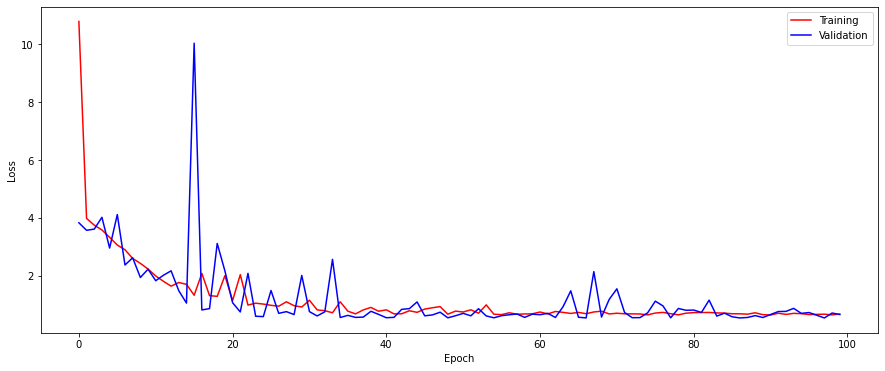

RMSE:  0.820
R²:  0.070


In [ ]:
# Import a graph-plotting library
import matplotlib.pyplot as plt

# The next few lines plot our loss values for each epoch to a scatter-plot
epochs = range(len(train_loss))
plt.figure(figsize=(15, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs, train_loss, 'r-', label='Training')
plt.plot(epochs, val_loss, 'b-', label='Validation')
plt.legend()
plt.show()

#from sklearn.metrics import mean_squared_error, r2_score
from torchmetrics import MeanSquaredError, R2Score

mean_squared_error = MeanSquaredError(squared=False)  #squared (bool) – If True returns MSE value, if False returns RMSE value.
print("RMSE: ", "{:.3f}".format(mean_squared_error(torch.as_tensor(test_predictions), torch.as_tensor(test_targets))))

r2_score = R2Score()
print("R²: ", "{:.3f}".format(r2_score(torch.as_tensor(test_predictions),torch.as_tensor(test_targets))))

#### Interpreting the Loss Curves

Loss curves can tell us a lot about training and take a bit of practice to interpret, but here's a quick overview of what they typically mean.

**The loss bounces around wildy** \
The learning rate is far too high and the model isn't able to settle upon a set of parameters.

**The loss goes down sharply then quickly flattens out** \
The learning rate is a bit too high, so is likely not finding the best set of parameters.

**The loss doesn't stop going down** \
Either the learning rate is too low, or the number of epochs (number of passes throught the entire dataset) isn't large enough. 100 epochs should be enough for this dataset, so it's likely that the learning rate is too low.

**Both losses go down, the validation loss starts going up again** \
The model is overfitting to the training dataset. This indicates that the model is being trained for too many epochs, or it could indicate a deeper problem with the model/dataset.

**The ideal loss curve** \
Should have a fairly rapid descent, then slowly smooth out to a near horizontal line.

*Although this is what these typically mean, it may not necessarily be true!*

#### Plotting the Predictions and Targets

Now we've seen the model loss, we'll take a look at how our predictions compare to the targets.

A common way for regression tasks like this one is to plot the targets and predictions on a scatter plot. This shows us for each target value on the x-axis, what our model predicted on the y-axis.

The graph for a perfectly performing model will look like a staight line from the bottom-left to the top-right, indicating that every predicted value matched the target value exactly - though this is practically impossible.

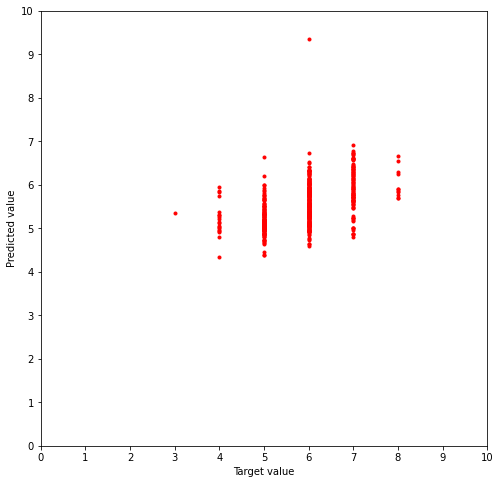

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlabel("Target value")
plt.ylabel("Predicted value")
plt.xlim((0, 10))
plt.ylim((0, 10))
plt.xticks([i for i in range(0, 11)])
plt.yticks([i for i in range(0, 11)])
plt.plot(test_targets, test_predictions, 'r.')
plt.show()

## Improve Performance
Now is the time to see how well you can get the model to perform! How high of an R² score can you get? By tweaking the model, optimiser and loss function it's possible to achieve an R² value of over `0.33`. The optimal value for R² is 1 so even 0.33 is not very good. Usually you would want a value of at least 0.7 to say the predicted and ground truth values are correlated. This is maybe due to the fact we made the problem a regression problem, and is better modeled as a classification problem instead. In the lab02b notebook we will try to turn this problem into a classification problem and see what happens.

### The Model
The model architecture is an obvious choice for improving our results. The current model is a 2-layer MLP with a hidden size of 20.

<font color='red'>Improve performance by modifying the model in the the "Define the Model" section</font>

Here are a few ideas you can try to improve performance:
 * Change the hidden size
 * Change the activation function
  * [Check out the PyTorch docs](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a list of options. Common choices are ReLU, ELU, LeakyReLU, Sigmoid and Tanh.
 * Make the model deeper with more layers

### The Loss Function
The loss function we used is standard for regression tasks, but it has a bit of a problem. It is very sensitive to outliers, which means that we unfairly punish the model for making bad predictions on values which don't really fit into the dataset in the first place!

Try the below loss functions and see which works best.

<font color='red'>Improve performance by modifying the loss function in the the "Set Up the Loss Function" section</font>

```python
# L1 loss handles outliers better, but usually doesn't perform as well on the rest of the dataset
loss_func = nn.L1Loss()
# Smooth L1 Loss (aka Huber loss) is a combination of L1 and MSE loss, with the benefits of both
loss_func = nn.SmoothL1Loss()
```

### The Optimiser
So far we're only using the stochastic gradient descent (SGD) optimizer, which is the simplest type of optimiser. Try one of the below optimisers and play around with different parameters learning rates and momentum.

<font color='red'>Improve performance by modifying the optimiser in the the "Set Up the Optimiser" section</font>

```python
# Add momentum to the model to make training more stable
torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)
# Try a more complex optimiser like Adam (this is usually recommended as the default optimiser). Adam is a good general purpose optimizer since it will automatically adjust the learning during training, so it make tunning the optimizer easier.
torch.optim.Adam(model.parameters(), lr=0.001)
```




## Classification problem instead

Lets try to solve this problem again but as a classification problem instead. Head over to lab02b notebook for us to have a crack at that.